In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import nltk

from gensim.models import KeyedVectors

# Loading a google embedding

In [8]:
## load the word embeddings from the google news vectors. Load it once.

#embeddings = KeyedVectors.load_word2vec_format('../../Data/GoogleNews-vectors-negative300.bin', binary=True)


In [9]:
## Building a word embeddings for the small subset that is required in here

f = open('../../Data/word_vectors/capitals.txt', 'r').read()
set_words = set(nltk.word_tokenize(f))
select_words = words = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 
                        'village', 'country', 'continent', 'petroleum', 'joyful']
for w in select_words:
    set_words.add(w)


def get_word_embeddings(embeddings):
    '''
        Get the word embeddings
    '''
    word_embeddings = {}
    for word in embeddings.vocab:
        if word in set_words:
            word_embeddings[word] = embeddings[word]
            
    return word_embeddings

In [10]:
word_embeddings = get_word_embeddings(embeddings)
print(len(word_embeddings))

243


In [11]:
pickle.dump(word_embeddings, open( "word_embeddings_subset.p", "wb" ) )

# Load Word embeddings from pickle file

In [13]:
word_embeddings = pickle.load(open('word_embeddings_subset.p','rb'))
len(word_embeddings)

243

In [16]:
word_embeddings['Spain'].size ## The size of the word embeddings

300

# Predict relationships between words

The cosine similarity function is:
$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$
$A$ and $B$ represent the word vectors and $A_i$ or $B_i$ represent index i of that vector. & Note that if A and B are identical, you will get $cos(\theta) = 1$.

- Otherwise, if they are the total opposite, meaning, $A= -B$, then you would get $cos(\theta) = -1$.
- If you get $cos(\theta) =0$, that means that they are orthogonal (or perpendicular).
- Numbers between 0 and 1 indicate a similarity score.
- Numbers between -1-0 indicate a dissimilarity score.

In [17]:
def cosine_similarity(A,B):
    '''
        Returns the cosine similarity between vectors A and B
    '''
    
    d = np.dot(A,B)
    norm_a = np.sqrt(np.dot(A,A))
    norm_b = np.sqrt(np.dot(B,B))
    
    cos = d / (norm_a * norm_b)
    
    return cos

In [18]:
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king,queen)  ## between 0 and 1 is similar

0.6510957

You will now implement a function that computes the similarity between two vectors using the Euclidean distance. Euclidean distance is defined as:
$$ \begin{aligned} d(\mathbf{A}, \mathbf{B})=d(\mathbf{B}, \mathbf{A}) =\sqrt{\left(A_{1}-B_{1}\right)^{2}+\left(A_{2}-B_{2}\right)^{2}+\cdots+\left(A_{n}-B_{n}\right)^{2}} \\ =\sqrt{\sum_{i=1}^{n}\left(A_{i}-B_{i}\right)^{2}} \end{aligned}$$

- $n$ is the number of elements in the vector
- $A$ and $B$ are the corresponding word vectors.
- The more similar the words, the more likely the Euclidean distance will be close to 0.

In [20]:
def euclidean_distance(A,B):
    '''
        Calculate the euclidean distance between two vectors
    '''
    
    d = np.linalg.norm(A - B)
    
    return d

In [22]:
king = word_embeddings['king']
queen = word_embeddings['queen']

euclidean_distance(king,queen) ## somewhat similar

2.4796925

## Finding the capital of the country

In [25]:
def get_country(city1, country1, city2, embeddings):
    '''
        Find the most likely country (country2) for a given set of inputs
    '''
    
    city1_embed = embeddings[city1]
    country1_embed = embeddings[country1]
    city2_embed = embeddings[city2]
    
    # get embedding of country 2 (it's a combination of the embeddings of country 1, city 1 and city 2)
    # Remember: King - Man + Woman = Queen
    
    vec = country1_embed - city1_embed + city2_embed
    
    similarity = -1
    
    country = ''
    
    group = set((city1, country1, city2))
    
    ## iterate through all words in the embedding
    for word in embeddings.keys():
        
        if word not in group:
            
            word_embedd = embeddings[word]
            
            cos_similarity = cosine_similarity(vec, word_embedd) ## find cos similarity
            
            if cos_similarity > similarity:
                
                similarity = cos_similarity
                
                country = (word, similarity)
                
    return country

In [33]:
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

In [34]:
get_country('London', 'England', 'Moscow', word_embeddings)

('Russia', 0.6954342)

## Model Accuracy

In [37]:
## load a sample country data set

data = pd.read_csv('../../Data/word_vectors/capitals.txt', sep=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']
data.head()

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


In [44]:
def get_accuracy(data, embeddings):
    '''
        get the overall accuracy of the word embedding model
    '''
    
    correct = 0
    
    for i, row in data.iterrows():
        
        city1 = row['city1']
        country1 = row['country1']
        city2 = row['city2']
        country2 = row['country2']
        
        predict_country, predict_similarity = get_country(city1, country1, city2, embeddings)
        
        if predict_country == country2:
            correct += 1
            
    total_data = len(data)
    
    accuracy = correct / total_data
    
    return accuracy

In [49]:
print(f'Model Accuracy : {get_accuracy(data, word_embeddings)*100:10.2f}')

Model Accuracy :      91.92


# PCA

Now you will explore the distance between word vectors after reducing their dimension. The technique we will employ is known as principal component analysis (PCA). As we saw, we are working in a 300-dimensional space in this case. Although from a computational perspective we were able to perform a good job, it is impossible to visualize results in such high dimensional spaces.

You can think of PCA as a method that projects our vectors in a space of reduced dimension, while keeping the maximum information about the original vectors in their reduced counterparts. In this case, by maximum infomation we mean that the Euclidean distance between the original vectors and their projected siblings is minimal. Hence vectors that were originally close in the embeddings dictionary, will produce lower dimensional vectors that are still close to each other.

You will see that when you map out the words, similar words will be clustered next to each other. For example, the words 'sad', 'happy', 'joyful' all describe emotion and are supposed to be near each other when plotted. The words: 'oil', 'gas', and 'petroleum' all describe natural resources. Words like 'city', 'village', 'town' could be seen as synonyms and describe a similar thing.

Before plotting the words, you need to first be able to reduce each word vector with PCA into 2 dimensions and then plot it. The steps to compute PCA are as follows:
- Mean normalize the data
- Compute the covariance matrix of your data ($\Sigma$).
- Compute the eigenvectors and the eigenvalues of your covariance matrix
- Multiply the first K eigenvectors by your normalized data. The transformation should look something as follows:


In [50]:
def compute_pca(X, n_components=2):
    '''
    Compute the PCA
        
    Input:
          X: of dimension (m,n) where each row corresponds to a word vector
          n_components: Number of components you want to keep.
    Output:
          X_reduced: data transformed in 2 dims/columns + regenerated original data
    '''
    
    # mean center the data
    X_demeaned = X - np.mean(X,axis=0)
    print('X_demeaned.shape: ',X_demeaned.shape)
    
    # calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar=False)
    
    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')
    
    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)
    
    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]
    
    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]
    
    # sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]
    
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    eigen_vecs_subset = eigen_vecs_sorted[:,0:n_components]
    
    X_reduced = np.dot(eigen_vecs_subset.transpose(),X_demeaned.transpose()).transpose()

    return X_reduced

In [51]:
np.random.seed(1)
X = np.random.rand(3, 10)
print(X)
X_reduced = compute_pca(X, n_components=2)
print("Your original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
  1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
  3.96767474e-01 5.38816734e-01]
 [4.19194514e-01 6.85219500e-01 2.04452250e-01 8.78117436e-01
  2.73875932e-02 6.70467510e-01 4.17304802e-01 5.58689828e-01
  1.40386939e-01 1.98101489e-01]
 [8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
  8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02
  1.69830420e-01 8.78142503e-01]]
X_demeaned.shape:  (3, 10)
Your original matrix was (3, 10) and it became:
[[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]]


In [53]:
def get_vectors(embeddings, words):
    """
    Input:
        embeddings: a word 
        fr_embeddings:
        words: a list of words
    Output: 
        X: a matrix where the rows are the embeddings corresponding to the rows on the list
        
    """
    m = len(words)
    X = np.zeros((1, 300))
    for word in words:
        english = word
        eng_emb = embeddings[english]
        X = np.row_stack((X, eng_emb))
    X = X[1:,:]
    return X

In [54]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


X_demeaned.shape:  (11, 300)


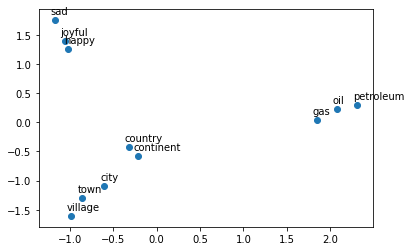

In [55]:
# We have done the plotting for you. Just run this cell.
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()